In [1]:
from deap import base, creator, tools, algorithms
import deap.benchmarks.tools as bt
import matplotlib.pyplot as plt
import numpy as np 
import pickle
from numpy import pi, sin
import operator
import statistics
import pandas as pd
from collections import OrderedDict

creator.create("obj", base.Fitness, weights=(-1.0,-1.0))

creator.create("Ind", list, fitness=creator.obj)

In [2]:
checkpoint_file = "checkpoint.pkl"
with open(checkpoint_file, "rb") as cp_file:
    cp = pickle.load(cp_file)

In [3]:
cp["input_file"]

{'control_variables': {'total_pf': {'min': 0.05, 'max': 0.07},
  'sine_a_x': {'min': 0.0, 'max': 2.0},
  'sine_b_x': {'min': 0.0, 'max': 1.57},
  'sine_c_x': {'min': 0.0, 'max': 6.28},
  'sine_a_y': {'min': 0.0, 'max': 2.0},
  'sine_b_y': {'min': 0.0, 'max': 1.57},
  'sine_c_y': {'min': 0.0, 'max': 6.28}},
 'evaluators': {'openmc': {'order': 0,
   'input_script': ['aprun -n 1 -d 1 --env OMP_NUM_THREADS=1 python ',
    'fhr_assem_openmc.py'],
   'execute': [['aprun -n 1 -d 64 --env OMP_NUM_THREADS=64 openmc-0.12.2']],
   'inputs': ['total_pf',
    'sine_a_x',
    'sine_b_x',
    'sine_c_x',
    'sine_a_y',
    'sine_b_y',
    'sine_c_y'],
   'output_script': ['aprun -n 1 -d 1 --env OMP_NUM_THREADS=1 python ',
    'fhr_assem_openmc_output.py'],
   'outputs': ['total_pf', 'ppf', 'keff']}},
 'constraints': {'keff': {'operator': ['>='], 'constrained_val': [1.38]}},
 'algorithm': {'objective': ['min', 'min'],
  'weight': [1.0, 1.0],
  'optimized_variable': ['total_pf', 'ppf'],
  'pop_size': 

In [4]:
def get_ind_list(pop_list, index):
    ind_list = [] 
    for pop in pop_list:
        ind_list.append(pop[index])
    return ind_list

In [5]:
logbook = cp["logbook"]

In [6]:
def plot_1_obj(logbook, index, obj_name, short_name, save_fig, save_fig_title):
    gen = logbook.select("gen")
    obj_avg = get_ind_list(logbook.chapters["oup"].select("avg"), index)
    obj_std = get_ind_list(logbook.chapters["oup"].select("std"), index)
    obj_min = get_ind_list(logbook.chapters["oup"].select("min"), index)
    obj_max = get_ind_list(logbook.chapters["oup"].select("max"), index)
    plt.rc('font', family='serif')
    fig, ax = plt.subplots(figsize=(15,7))
    ax.errorbar(gen, obj_avg, yerr=obj_std, label="Ave "+ short_name, capsize=5)
    ax.plot(gen, obj_min, "*-", label="Min "+ short_name)
    ax.plot(gen, obj_max, "*-", label="Max "+ short_name)
    ax.set_xlabel("Generation", fontsize=22)
    ax.set_ylabel(obj_name, fontsize=22)
    ax.grid()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, fontsize=18, bbox_to_anchor = [1.0, 1.0])
    ax.set_title(obj_name + " Evolution", fontsize=24)
    if save_fig:
        plt.savefig(save_fig_title,bbox_inches='tight')

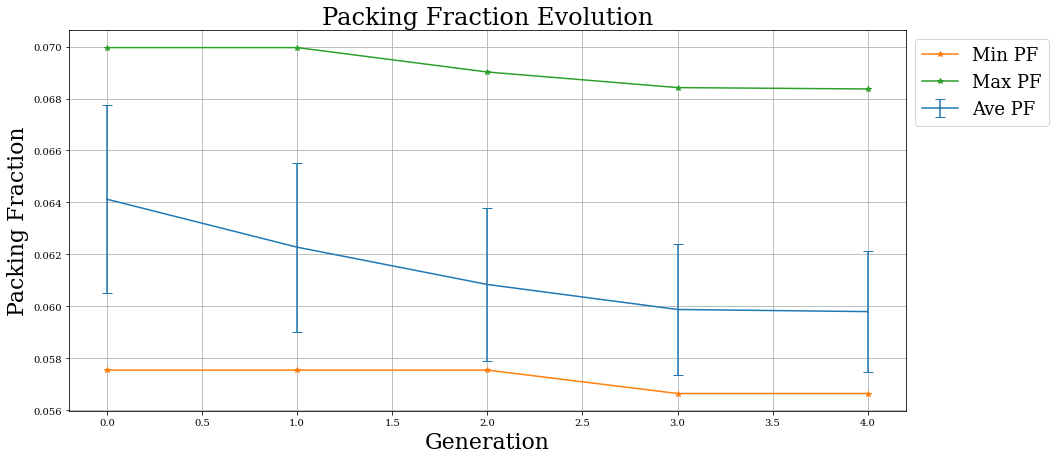

In [7]:
plot_1_obj(logbook, 0, "Packing Fraction", "PF", False, "assem-obj-2-pf-evol.png")

##### plot_1_obj(logbook, 1, "Power Peaking Factor", "PPF", False, "assem-obj-1-ppf-evol.png")

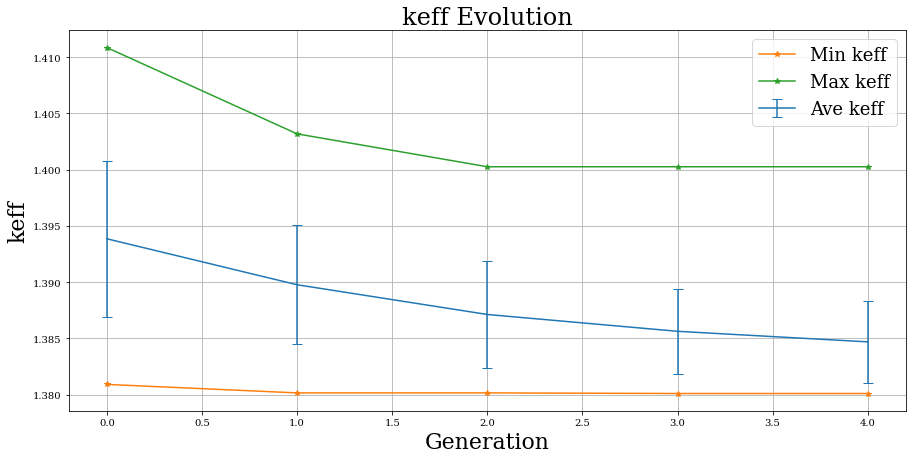

In [8]:
plot_1_obj(logbook, 2, "keff", "keff", False, "")

In [9]:
results = cp["all"]
all_pop = []
ref = np.array([0.07,1.9])
for pop in results["populations"]:
    non_dom = tools.sortNondominated(pop, k=len(pop), first_front_only=True)[0]
    hypervol = bt.hypervolume(non_dom, ref)
    print(hypervol)

0.009894642900819515
0.00991467157025796
0.009973628056537624
0.010547218630587557
0.01058721516087116


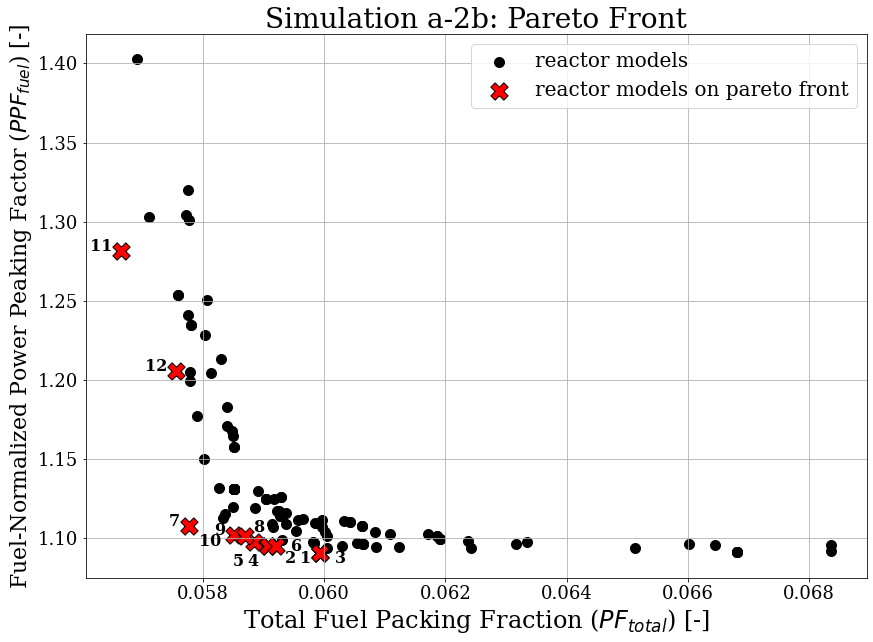

In [10]:
results = cp["all"]
final_pop = results["populations"][-1]
final_non_dom = tools.sortNondominated(final_pop, k=len(final_pop), first_front_only=True)[0]

fig, ax = plt.subplots(figsize=(14, 10))
count1, count2 = 0, 0
for ind in final_pop:
    if count1 == 0:
        ax.scatter(ind.output[0], ind.output[1], marker='o', edgecolors='black', alpha=1, s=100, color="black", label="reactor models")
        count1 += 1
    else:
        ax.scatter(ind.output[0], ind.output[1], marker='o', edgecolors='black', alpha=1, s=100, color="black")
num = 1
prev_0, prev_1 = 0, 0
for ind in final_non_dom:
    if count2 == 0:
        ax.scatter(ind.output[0], ind.output[1], marker="X", s=300, edgecolors='black', alpha=1, color="red",
                   label="reactor models on pareto front")
        count2 += 1
    else:
        #ax.plot(ind.output[0], ind.output[1], 'rx', alpha=0.74, ms=8, mew=3)
        ax.scatter(ind.output[0], ind.output[1], marker="X", s=300, edgecolors='black', alpha=1, color="red")
    if num < 100:
        offset_0, offset_1 = abs(ind.output[0]-prev_0), abs(ind.output[1]-prev_1)
        offset_y = 0
        if num < 10:
            offset_x = -15
        else:
            offset_x = -20
        if offset_0 < 0.001 and offset_1 < 0.001:
            offset_x -= 15
        if num in [1,2,3,10]:
            offset_y = -10
        if num in [4,5]:
            offset_y = -20
        if num in [3,6]:
            offset_x = 20
        if num in [8]:
            offset_y = 10
            offset_x = 5
        if num in [6]:
            offset_y = -5
        ax.annotate(str(num), (ind.output[0], ind.output[1]), textcoords="offset points", 
                    xytext=(offset_x,offset_y), ha='center', weight='bold', fontsize=16) 
        prev_0, prev_1 = ind.output[0], ind.output[1]
    num += 1
#ax.set_xlim(0.01, 0.04)
#ax.set_ylim(1.0, 1.6)
ax.grid()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=20, bbox_to_anchor = [1.0, 1.0])
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_ylabel(r'Fuel-Normalized Power Peaking Factor ($PPF_{fuel}$) [-]',fontsize=22)
ax.set_xlabel(r'Total Fuel Packing Fraction ($PF_{total}$) [-]',fontsize=24)
ax.set_title('Simulation a-2b: Pareto Front',fontsize=28)
plt.savefig("assem-obj-2-pfppf-pareto",bbox_inches='tight', dpi=300)

In [11]:
len(final_non_dom)

12

In [12]:
midpoints_discr_x = np.array([ 6.18871652,  8.22745601, 10.2661955,  12.304935,  14.34367449, 16.38241398,
 18.42115347, 20.45989297, 22.49863246, 24.53737195])
midpoints_discr_y = np.array([19.775, 16.525, 13.275, 10.025,  6.775,  3.525])
def calc_pf_distr(ind, pf_present):
    if pf_present:
        total_pf, sine_a_x, sine_b_x, sine_c_x, sine_a_y, sine_b_y, sine_c_y = ind[0], ind[1], ind[2], ind[3], ind[4], ind[5], ind[6]
    else:
        sine_a_x, sine_b_x, sine_c_x, sine_a_y, sine_b_y, sine_c_y = ind[0], ind[1], ind[2], ind[3], ind[4], ind[5]
    
    sine_val_discr_x = sine_a_x * sin(sine_b_x * midpoints_discr_x + sine_c_x) + 2
    sine_val_discr_y = sine_a_y * sin(sine_b_y * midpoints_discr_y + sine_c_y) + 2
    sine_val_distr_xy = sine_val_discr_y.reshape(6,1) * sine_val_discr_x.reshape(1,10) 
    vol_triso = 0.0003181623994807103
    vol_total = 419.3793150536547
    vol_slice = 6.989655250894246
    no_trisos = total_pf * vol_total / vol_triso
    triso_distr = sine_val_distr_xy / sum(sum(sine_val_distr_xy)) * no_trisos
    pf_distr = triso_distr * vol_triso / vol_slice
    return pf_distr

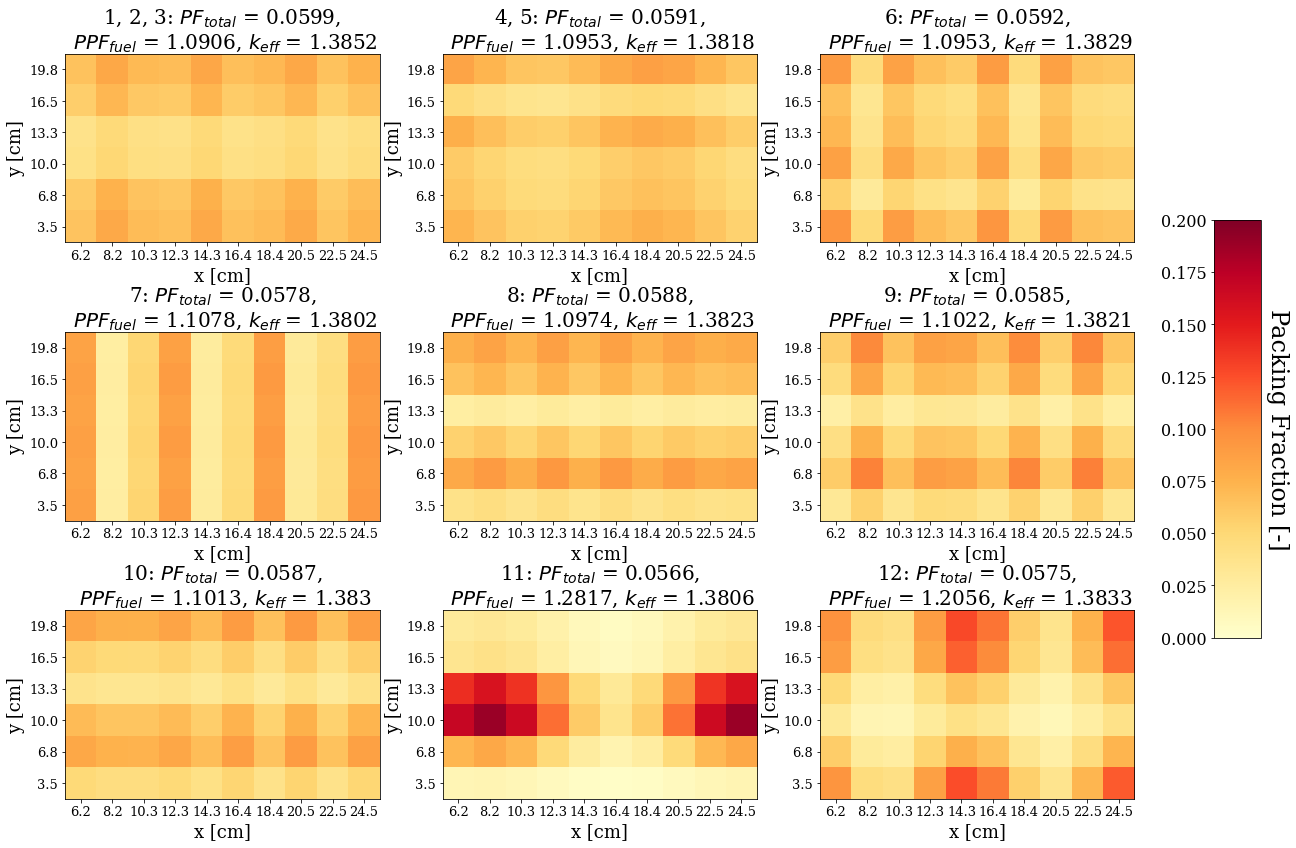

In [13]:
midpoints_discr_x_rounded = [ '%.1f' % elem for elem in midpoints_discr_x]
midpoints_discr_y_rounded = [ '%.1f' % elem for elem in midpoints_discr_y]
results = cp["all"]
fig, axes = plt.subplots(figsize=(22,14.5), nrows=3, ncols=3)
count = 0
prev_pf = 0
for i, ind in enumerate(final_non_dom):
    if ind[0] != prev_pf: 
        ax = axes.flat[count]
        count += 1
        pf_distr = calc_pf_distr(ind, True)
        im = ax.imshow(pf_distr, vmin=0, vmax=0.2,cmap="YlOrRd")
        if i+1 == 1:
            nums = "1, 2, 3"
        elif i+1 == 4:
            nums = "4, 5"
        else:
            nums = str(i+1)
        ax.set_title(nums+": $PF_{total}$ = "+str(round(ind.output[0],4)) 
                     + ",\n $PPF_{fuel}$ = "+str(round(ind.output[1],4)) 
                     + ", $k_{eff}$ = "+str(round(ind.output[2],4)), fontsize=20)
        ax.set_xlabel("x [cm]", fontsize=18)
        ax.set_ylabel("y [cm]", fontsize=18)
        ax.set_xticks(ticks=np.arange(0,10,1),labels=midpoints_discr_x_rounded)
        ax.set_yticks(ticks=np.arange(0,6,1), labels=midpoints_discr_y_rounded)
        ax.tick_params(axis='both', which='major', labelsize=13)
        prev_pf = ind[0]
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.3, 0.03, 0.4])
cb = fig.colorbar(im, cax=cbar_ax)
cbar_ax.yaxis.set_ticks_position('left')
cb.ax.tick_params(labelsize=16)
cb.set_label("Packing Fraction [-]", fontsize=24, rotation=270, labelpad=28)
plt.savefig("assem-obj-2-pfppf-pareto-distr.png",bbox_inches='tight', dpi=300)

10 0 4
[0.05664759206220748, 1.3538325078169846, 0.38027291685541825, 4.754273698936249, 1.7393167503990832, 0.4322688085487837, 3.0878227396115583]
[0.05993241065462622, 0.26519221290534606, 1.089472375956854, 4.84640045066373, 0.5948502624395968, 1.5013598557891104, 3.027462055853223]
[0.05907719896184856, 0.3575191696122737, 0.4463287236594272, 5.782737667601853, 0.5937196132209892, 0.8513713872361879, 3.7381301843702457]


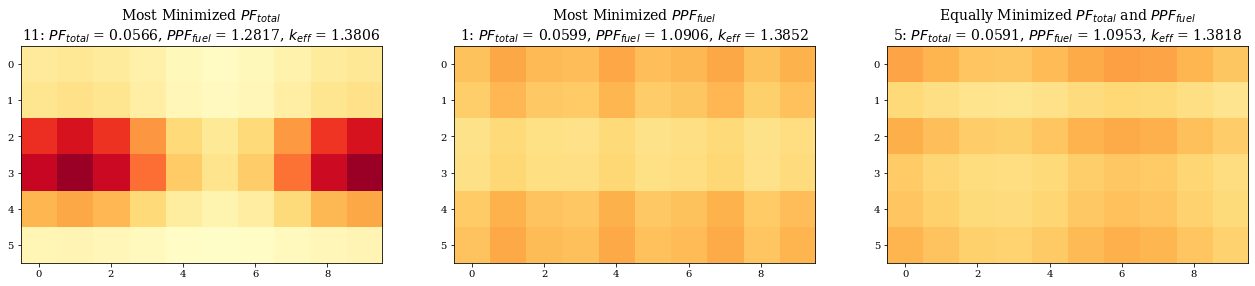

In [14]:
results = cp["all"]
pop = results["populations"][-1]
non_dom = tools.sortNondominated(pop, k=len(pop), first_front_only=True)[0]
obj_0 = np.array([item.fitness.values[0] for item in non_dom])
obj_1 = np.array([item.fitness.values[1] for item in non_dom])
pf_min = np.argsort(obj_0)[0]
ppf_min = np.argsort(obj_1)[0]
equal_min = 5-1
midpoints_discr_x_rounded = [ '%.1f' % elem for elem in midpoints_discr_x]
midpoints_discr_y_rounded = [ '%.1f' % elem for elem in midpoints_discr_y]
fig, axes = plt.subplots(figsize=(22,7.5), nrows=1, ncols=3)
count = 0
print(pf_min, ppf_min, equal_min)
for i in [pf_min, ppf_min, equal_min]:
    ind = non_dom[i]
    pf_distr = calc_pf_distr(ind, True)
    print(ind)
    ax = axes.flat[count]
    count += 1
    im = ax.imshow(pf_distr, vmin=0, vmax=0.2,cmap="YlOrRd")
    if i == pf_min:
        title_start = "Most Minimized $PF_{total}$ \n"
    elif i == ppf_min:
        title_start = "Most Minimized $PPF_{fuel}$ \n"
    elif i == equal_min:
        title_start = "Equally Minimized $PF_{total}$ and $PPF_{fuel}$ \n"
    ax.set_title(title_start + str(i+1)+": $PF_{total}$ = "+str(round(ind.output[0],4)) + ", $PPF_{fuel}$ = "+str(round(ind.output[1],4))+ ", $k_{eff}$ = "+str(round(ind.output[2],4)), 
                 fontsize=14)

10 0 4
i 10
3 48
[0.05664759206220748, 1.3538325078169846, 0.38027291685541825, 4.754273698936249, 1.7393167503990832, 0.4322688085487837, 3.0878227396115583]
STD 0.053757905075866
i 0
2 48
[0.05993241065462622, 0.26519221290534606, 1.089472375956854, 4.84640045066373, 0.5948502624395968, 1.5013598557891104, 3.027462055853223]
STD 0.013364229244769477
i 4
4 9
[0.05907719896184856, 0.3575191696122737, 0.4463287236594272, 5.782737667601853, 0.5937196132209892, 0.8513713872361879, 3.7381301843702457]
STD 0.01278566451018525


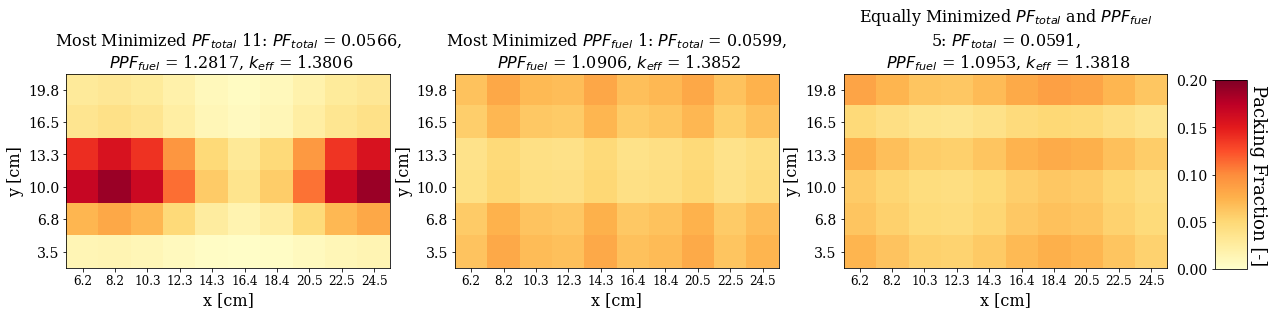

In [15]:
results = cp["all"]
pop = results["populations"][-1]
non_dom = tools.sortNondominated(pop, k=len(pop), first_front_only=True)[0]
obj_0 = np.array([item.fitness.values[0] for item in non_dom])
obj_1 = np.array([item.fitness.values[1] for item in non_dom])
pf_min = np.argsort(obj_0)[0]
ppf_min = np.argsort(obj_1)[0]
equal_min = 5-1
midpoints_discr_x_rounded = [ '%.1f' % elem for elem in midpoints_discr_x]
midpoints_discr_y_rounded = [ '%.1f' % elem for elem in midpoints_discr_y]
fig, axes = plt.subplots(figsize=(22,7.5), nrows=1, ncols=3)
count = 0
print(pf_min, ppf_min, equal_min)
num = 1
for i in [pf_min, ppf_min, equal_min]:
    ind = non_dom[i]
    print("i",i)
    print(ind.gen, ind.num)
    print(ind)
    ax = axes.flat[count]
    count += 1
    pf_distr = calc_pf_distr(ind, True)
    #print(i+1, ind.output[2])
    print("STD", np.std(pf_distr))
    #for row in pf_distr:
    #    print(np.max(row)- np.min(row))
        #print(np.min(row))
    #for j in range(10):
    #    col = pf_distr[:, j]
    #    print(np.max(col)-np.min(col))
        #print(np.min(col))
    im = ax.imshow(pf_distr, vmin=0, vmax=0.2,cmap="YlOrRd")
    if i == pf_min:
        title_start = "Most Minimized $PF_{total}$ "
    if i == equal_min:
        title_start = "Equally Minimized $PF_{total}$ and $PPF_{fuel}$ \n"
    if i == ppf_min:
        title_start = "Most Minimized $PPF_{fuel}$ "
    ax.set_title(title_start + str(i+1)+": $PF_{total}$ = "+str(round(ind.output[0],4)) + ",\n $PPF_{fuel}$ = "+str(round(ind.output[1],4))+ ", $k_{eff}$ = "+str(round(ind.output[2],4)), 
                 fontsize=16)
    ax.set_xlabel("x [cm]", fontsize=16)
    ax.set_ylabel("y [cm]", fontsize=16)
    ax.set_xticks(ticks=np.arange(0,10,1),labels=midpoints_discr_x_rounded, fontsize=12)
    ax.set_yticks(ticks=np.arange(0,6,1), labels=midpoints_discr_y_rounded, fontsize=14)
    num += 1
fig.subplots_adjust(right=0.82)
cbar_ax = fig.add_axes([0.85, 0.32, 0.02, 0.35])
cb = fig.colorbar(im, cax=cbar_ax)
cbar_ax.yaxis.set_ticks_position('left')
cb.ax.tick_params(labelsize=14)
cb.set_label("Packing Fraction [-]", fontsize=18, rotation=270, labelpad=20)
plt.savefig("a-2b-comparison-reactors.png",bbox_inches='tight')

0 2 48
[0.05993241065462622, 0.26519221290534606, 1.089472375956854, 4.84640045066373, 0.5948502624395968, 1.5013598557891104, 3.027462055853223]
(0.05993241065462622, 1.090623858388058, 1.3851789053386658)
1 0.018
2 0.016
3 0.011
4 0.011
5 0.017
6 0.018
10 3 48
[0.05664759206220748, 1.3538325078169846, 0.38027291685541825, 4.754273698936249, 1.7393167503990832, 0.4322688085487837, 3.0878227396115583]
(0.05664759206220748, 1.2816960826625912, 1.3805753364784228)
1 0.026
2 0.032
3 0.127
4 0.153
5 0.066
6 0.011


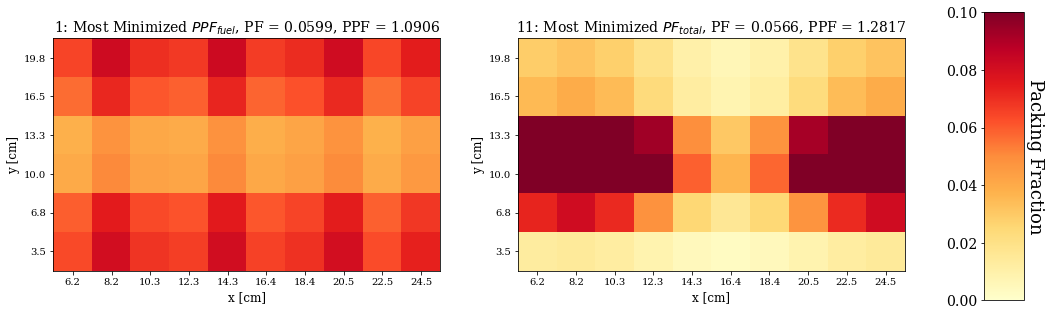

In [16]:
midpoints_discr_x_rounded = [ '%.1f' % elem for elem in midpoints_discr_x]
midpoints_discr_y_rounded = [ '%.1f' % elem for elem in midpoints_discr_y]
results = cp["all"]
obj_0 = np.array([item.output[0] for item in final_non_dom])
obj_1 = np.array([item.output[1] for item in final_non_dom])
pf_min = np.argsort(obj_0)[0]
ppf_min = np.argsort(obj_1)[0]
fig, axes = plt.subplots(figsize=(11, 10), nrows=1, ncols=2)
count = 0
num = 1
for i, ind in enumerate(final_non_dom):
    if i in [ppf_min, pf_min]:
        print(i, ind.gen, ind.num)
        print(ind)
        print(ind.output)
        if i == pf_min:
            title = str(num)+": Most Minimized $PF_{total}$"
        if i == ppf_min:
            title = str(num)+": Most Minimized $PPF_{fuel}$"
        ax = axes.flat[count]
        count += 1
        pf_distr = calc_pf_distr(ind, True)
        for i, row in enumerate(pf_distr):
            print(i+1, round(np.max(row)- np.min(row),3))
        #for i in range(10):
        #    col = pf_distr[:, i]
        #    print(i+1, round(np.max(col)-np.min(col),3))
        im = ax.imshow(pf_distr, vmin=0, vmax=0.1,cmap="YlOrRd")
        title += ", PF = "+str(round(ind.output[0],4)) + ", PPF = "+str(round(ind.output[1],4))
        ax.set_title(title, fontsize=14)
        ax.set_xlabel("x [cm]", fontsize=12)
        ax.set_ylabel("y [cm]", fontsize=12)
        ax.set_xticks(ticks=np.arange(0,10,1),labels=midpoints_discr_x_rounded)
        ax.set_yticks(ticks=np.arange(0,6,1), labels=midpoints_discr_y_rounded)
    num += 1
fig.subplots_adjust(right=1.2)
cbar_ax = fig.add_axes([1.3, 0.3, 0.05, 0.4])
cb = fig.colorbar(im, cax=cbar_ax)
cbar_ax.yaxis.set_ticks_position('left')
cb.ax.tick_params(labelsize=14)
cb.set_label("Packing Fraction", fontsize=18, rotation=270, labelpad=20)
#plt.savefig("assem-obj-2-pfppf-most-minimized.png",bbox_inches='tight')

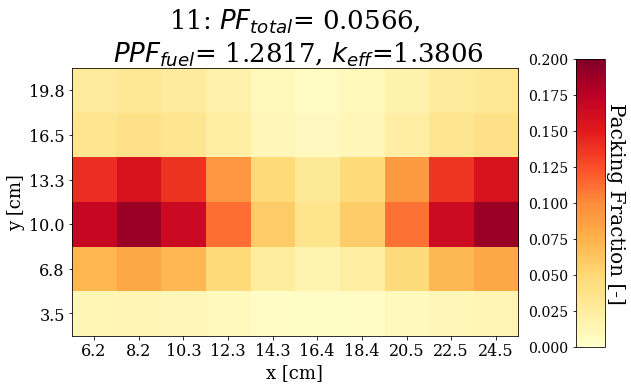

In [17]:
final_pop = results["populations"][-1]
final_non_dom = tools.sortNondominated(final_pop, k=len(final_pop), first_front_only=True)[0]
obj_0 = np.array([item.output[0] for item in final_non_dom])
pf_min = np.argsort(obj_0)[0]
pf_most_minimized = final_non_dom[pf_min]
pf_distr = calc_pf_distr(pf_most_minimized, True)
#print(pf_distr)
#for row in pf_distr:
    #print(np.max(row)- np.min(row))
    #print(np.min(row))
#for i in range(10):
    #col = pf_distr[:, i]
    #print(np.max(col)-np.min(col))
    #print(np.min(col))
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(pf_distr, vmin=0, vmax=0.2,cmap="YlOrRd")
ax.set_title(str(pf_min+1)+": $PF_{total}$= "+str(round(pf_most_minimized.output[0],4))+
             ",\n $PPF_{fuel}$= "+str(round(pf_most_minimized.output[1],4))+ 
             ", $k_{eff}$=" + str(round(pf_most_minimized.output[2],4)), fontsize=26)
ax.set_xlabel("x [cm]", fontsize=18)
ax.set_ylabel("y [cm]", fontsize=18)
ax.set_xticks(ticks=np.arange(0,10,1),labels=midpoints_discr_x_rounded, fontsize=16)
ax.set_yticks(ticks=np.arange(0,6,1), labels=midpoints_discr_y_rounded, fontsize=16)
cbar_ax = fig.add_axes([1.0, 0.25, 0.05, 0.5])
cb = fig.colorbar(im, cax=cbar_ax)
cbar_ax.yaxis.set_ticks_position('left')
cbar_ax.tick_params(labelsize=14) 
cb.set_label("Packing Fraction [-]", fontsize=20, rotation=270, labelpad=20)
plt.savefig("a-2b-pf-most-minimized.png",bbox_inches='tight', dpi=300)


0.08231819860343279
0.0720298845814926
0.048315474625571106
0.050718511914474365
0.07523195562489483
0.08097988172473594


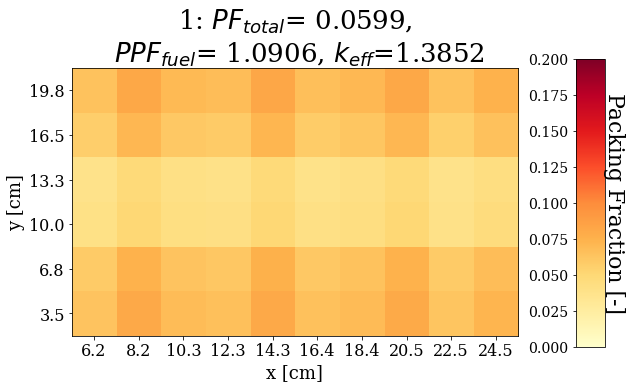

In [18]:
final_pop = results["populations"][-1]
final_non_dom = tools.sortNondominated(final_pop, k=len(final_pop), first_front_only=True)[0]
obj_1 = np.array([item.output[1] for item in final_non_dom])
ppf_min = np.argsort(obj_1)[0]
ppf_most_minimized = final_non_dom[ppf_min]
pf_distr = calc_pf_distr(ppf_most_minimized, True)
#print(pf_distr)
for row in pf_distr:
    #print(np.max(row)- np.min(row))
    print(np.max(row))
#for i in range(10):
 #   col = pf_distr[:, i]
    #print(np.max(col)-np.min(col))
  #  print(np.min(col))
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(pf_distr, vmin=0, vmax=0.2,cmap="YlOrRd")
ax.set_title(str(ppf_min+1)+": $PF_{total}$= "+str(round(ppf_most_minimized.output[0],4))+ 
             ",\n $PPF_{fuel}$= "+str(round(ppf_most_minimized.output[1],4))+ 
             ", $k_{eff}$=" + str(round(ppf_most_minimized.output[2],4)), fontsize=26)
ax.set_xlabel("x [cm]", fontsize=18)
ax.set_ylabel("y [cm]", fontsize=18)
ax.set_xticks(ticks=np.arange(0,10,1),labels=midpoints_discr_x_rounded, fontsize=16)
ax.set_yticks(ticks=np.arange(0,6,1), labels=midpoints_discr_y_rounded, fontsize=16)
cbar_ax = fig.add_axes([1.0, 0.25, 0.05, 0.5])
cb = fig.colorbar(im, cax=cbar_ax)
cbar_ax.yaxis.set_ticks_position('left')
cbar_ax.tick_params(labelsize=14) 
cb.set_label("Packing Fraction [-]", fontsize=22, rotation=270, labelpad=20)
plt.savefig("a-2b-ppf-most-minimized.png",bbox_inches='tight', dpi=300)


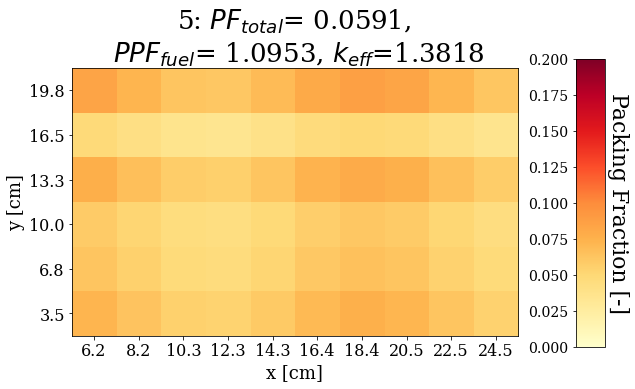

In [19]:
final_pop = results["populations"][-1]
final_non_dom = tools.sortNondominated(final_pop, k=len(final_pop), first_front_only=True)[0]
both_most_minimized = final_non_dom[4]
pf_distr = calc_pf_distr(both_most_minimized, True)
#print(pf_distr)
#for row in pf_distr:
    #print(np.max(row)- np.min(row))
#    print(np.max(row))
#for i in range(10):
    #col = pf_distr[:, i]
    #print(np.max(col)-np.min(col))
    #print(np.max(col))
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(pf_distr, vmin=0, vmax=0.2,cmap="YlOrRd")
ax.set_title( str(4+1)+": $PF_{total}$= "+str(round(both_most_minimized.output[0],4))+ 
             ", \n $PPF_{fuel}$= "+str(round(both_most_minimized.output[1],4))+ 
             ", $k_{eff}$=" + str(round(both_most_minimized.output[2],4)), fontsize=26)
ax.set_xlabel("x [cm]", fontsize=18)
ax.set_ylabel("y [cm]", fontsize=18)
ax.set_xticks(ticks=np.arange(0,10,1),labels=midpoints_discr_x_rounded, fontsize=16)
ax.set_yticks(ticks=np.arange(0,6,1), labels=midpoints_discr_y_rounded, fontsize=16)
cbar_ax = fig.add_axes([1.0, 0.25, 0.05, 0.5])
cb = fig.colorbar(im, cax=cbar_ax)
cbar_ax.yaxis.set_ticks_position('left')
cbar_ax.tick_params(labelsize=14) 
cb.set_label("Packing Fraction [-]", fontsize=22, rotation=270, labelpad=24)
plt.savefig("a-2b-both-most-minimized.png",bbox_inches='tight', dpi=300)


In [20]:
# compare 1 and 5's fission reaction rate and thermal flux. 

In [21]:
def max_ave_min_pf_distr_row(pf_distr):
    all_row = []
    for row in pf_distr:
        max_row = np.max(row)
        min_row = np.min(row)
        max_minus_min = max_row - min_row
        all_row.append(max_minus_min)
    return sum(all_row)/6, statistics.pstdev(all_row), max(all_row), all_row.index(max(all_row)), min(all_row), all_row.index(min(all_row))

In [22]:
def max_ave_min_pf_distr_col(pf_distr):
    all_col = []
    for i in range(10):
        col = pf_distr[:,i]
        max_col = np.max(col)
        min_col = np.min(col)
        max_minus_min = max_col - min_col
        all_col.append(max_minus_min)
    return sum(all_col)/10, statistics.pstdev(all_col), max(all_col), all_col.index(max(all_col)), min(all_col), all_col.index(min(all_col))

In [23]:
values_row, values_col = {}, {}
for i, ind in enumerate(final_non_dom):
    pf_distr = calc_pf_distr(ind, True)
    values_row[i+1] = max_ave_min_pf_distr_row(pf_distr)
    values_col[i+1] = max_ave_min_pf_distr_col(pf_distr)

In [24]:
ave, std, max_val, min_val = OrderedDict(), OrderedDict(), OrderedDict(), OrderedDict()
i = 5-1
ave["Most Minimized Both"] = values_row[i+1][0]
std["Most Minimized Both"] = values_row[i+1][1]
max_val["Most Minimized Both"] = values_row[i+1][2]
min_val["Most Minimized Both"] = values_row[i+1][4]
i = 3-1
ave["Most Minimized PF"] = values_row[i+1][0]
std["Most Minimized PF"] = values_row[i+1][1]
max_val["Most Minimized PF"] = values_row[i+1][2]
min_val["Most Minimized PF"] = values_row[i+1][4]
i = 1-1
ave["Most Minimized PPF"] = values_row[i+1][0]
std["Most Minimized PPF"] = values_row[i+1][1]
max_val["Most Minimized PPF"] = values_row[i+1][2]
min_val["Most Minimized PPF"] = values_row[i+1][4]       

data = [ave, std, max_val, min_val]
df_row_results = pd.DataFrame(data, index =['ave', 'std', 'max', 'min'])
df_row_results = df_row_results.transpose()
df_row_results.round(4)

,ave,std,max,min
Most Minimized Both,0.0207,0.0036,0.0257,0.0148
Most Minimized PF,0.0150,0.0030,0.0181,0.0106
Most Minimized PPF,0.0150,0.0030,0.0181,0.0106


In [25]:
ave, std, max_val, min_val = OrderedDict(), OrderedDict(), OrderedDict(), OrderedDict()
i = 5-1
ave["Most Minimized Both"] = values_col[i+1][0]
std["Most Minimized Both"] = values_col[i+1][1]
max_val["Most Minimized Both"] = values_col[i+1][2]
min_val["Most Minimized Both"] = values_col[i+1][4]
i = 3-1
ave["Most Minimized PF"] = values_col[i+1][0]
std["Most Minimized PF"] = values_col[i+1][1]
max_val["Most Minimized PF"] = values_col[i+1][2]
min_val["Most Minimized PF"] = values_col[i+1][4]
i = 1-1
ave["Most Minimized PPF"] = values_col[i+1][0]
std["Most Minimized PPF"] = values_col[i+1][1]
max_val["Most Minimized PPF"] = values_col[i+1][2]
min_val["Most Minimized PPF"] = values_col[i+1][4]   

data = [ave, std, max_val, min_val]
df_col_results = pd.DataFrame(data, index =['ave', 'std', 'max', 'min'])
df_col_results = df_col_results.transpose()
df_col_results.round(3)

,ave,std,max,min
Most Minimized Both,0.031,0.004,0.037,0.026
Most Minimized PF,0.030,0.003,0.034,0.027
Most Minimized PPF,0.030,0.003,0.034,0.027


In [26]:
# total variance
for i, ind in enumerate(final_non_dom):
    pf_distr = calc_pf_distr(ind, True)
    if i in [1-1, 3-1, 5-1]:
        print(round(np.std(pf_distr), 5))

0.01336
0.01336
0.01279
